In [742]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import time
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
import seaborn as sn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [243]:
np.set_printoptions(precision=5)

In [282]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.sample(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
4315,4316,2073,67,17,0,0,451,234,204,96,...,0,0,0,0,0,0,0,0,0,4
10587,10588,2995,155,30,134,58,3376,239,226,93,...,0,0,0,0,0,0,0,0,0,2
11404,11405,3004,235,6,216,9,5698,210,245,173,...,0,0,0,0,0,0,0,0,0,1
3802,3803,2178,131,26,108,53,1158,251,216,76,...,0,0,0,0,0,0,0,0,0,4
2997,2998,2389,83,22,268,27,992,244,196,70,...,0,0,0,0,0,0,0,0,0,3


In [7]:
df_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [284]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
# for col in col_normalize:
#     print(col)
#     l = []
#     for cover in sorted(df_train_norm.Cover_Type.unique()):
#         l.append( [v for v,k in zip(df_train_norm[col],df_train_norm['Cover_Type']) if k==cover]
#                 )
#     plt.boxplot(l)
#     plt.show()

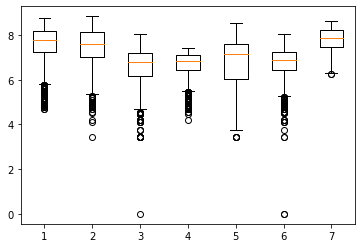

In [48]:
# l = []
# for cover in sorted(df_train_norm.Cover_Type.unique()):
#     l.append( [math.log(v+1) for v,k in zip(df_train_norm['Horizontal_Distance_To_Roadways'],df_train_norm['Cover_Type']) if k==cover]
#             )
# plt.boxplot(l)
# plt.show()

results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = PCA(n_components=k)
    pca.fit(df_train_norm.to_numpy(), df_train_norm['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [769]:
soils = [x for x in df_train_norm.columns if "Soil" in x]

for x in combinations(soils, 3):
    print(x)
    break

df_train_norm[soils].sum(axis=1).value_counts()

from tqdm.notebook import tqdm

classes = []
for n in tqdm(range(2,6)):
    for x in tqdm(combinations(soils, n)):
        pca = PCA(n_components=1)
        pca.fit(df_train_norm[list(x)].to_numpy(), df_train_norm['Cover_Type'].to_numpy())
        explained_variance = pca.explained_variance_ratio_.sum()
        classes.append([*x] + [" "]*(5-n) + [explained_variance])

r = pd.DataFrame(classes, columns=['S1','S2','S3','S4','S5','var'])
r['var'] -= 1
r[r['var']>=0].sort_values('var',ascending=False)

r.sort_values('var',ascending=False).to_csv('PCA results.csv', index=False)

results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = TruncatedSVD(n_components=k)
    pca.fit(df_train_norm.to_numpy(), df_train_norm['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [1]:
# class 1-2

In [2]:
# class 3-6
# class 3-4
# class 3-4-6

# Train Model

In [285]:
df_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,...,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,...,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,...,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,...,0,0,0,0,0,0,0,0,0,3


In [390]:
kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)

In [794]:
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False):
    X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    print('cv acc:', results.mean())
    print('split acc:', acc)
    print('time taken:', end-start)
    if display:
        matrix = cm(y_val, pred)
        print(matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Id','Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

## Baseline

### Best Model = ExtraTreesClassifier()

cv acc: 0.8658068783068783
split acc: 0.8482965931863727
time taken: 14.883414268493652
[0.7571  0.67234 0.81818 0.96078 0.92533 0.84469 0.96073]


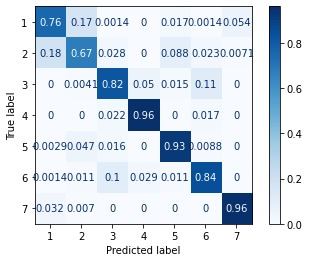

cv acc: 0.8642195767195766
split acc: 0.8434869739478958
time taken: 435.17900037765503
[0.75852 0.63262 0.82632 0.95798 0.93997 0.82834 0.96213]


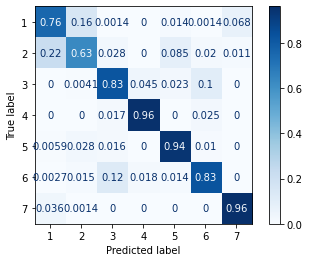

cv acc: 0.8653439153439153
split acc: 0.8448897795591183
time taken: 11.589077472686768
[0.76278 0.6766  0.81004 0.96078 0.92972 0.81744 0.95933]


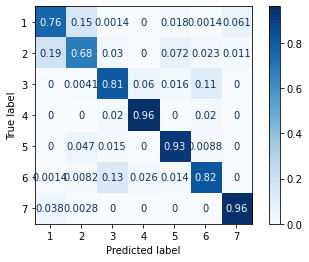

In [781]:
models = []
for clf in [ExtraTreesClassifier(n_jobs=-1, random_state=0),
           HistGradientBoostingClassifier(random_state=0),
           RandomForestClassifier(n_jobs=-1, random_state=0)]:
    
    models.append(score_model(clf,df_train))

### Best Ensemble = Mix 3

cv acc: 0.8854497354497355
split acc: 0.8639278557114228
time taken: 79.07685208320618
[0.76847 0.68936 0.85075 0.96779 0.94876 0.8515  0.97195]


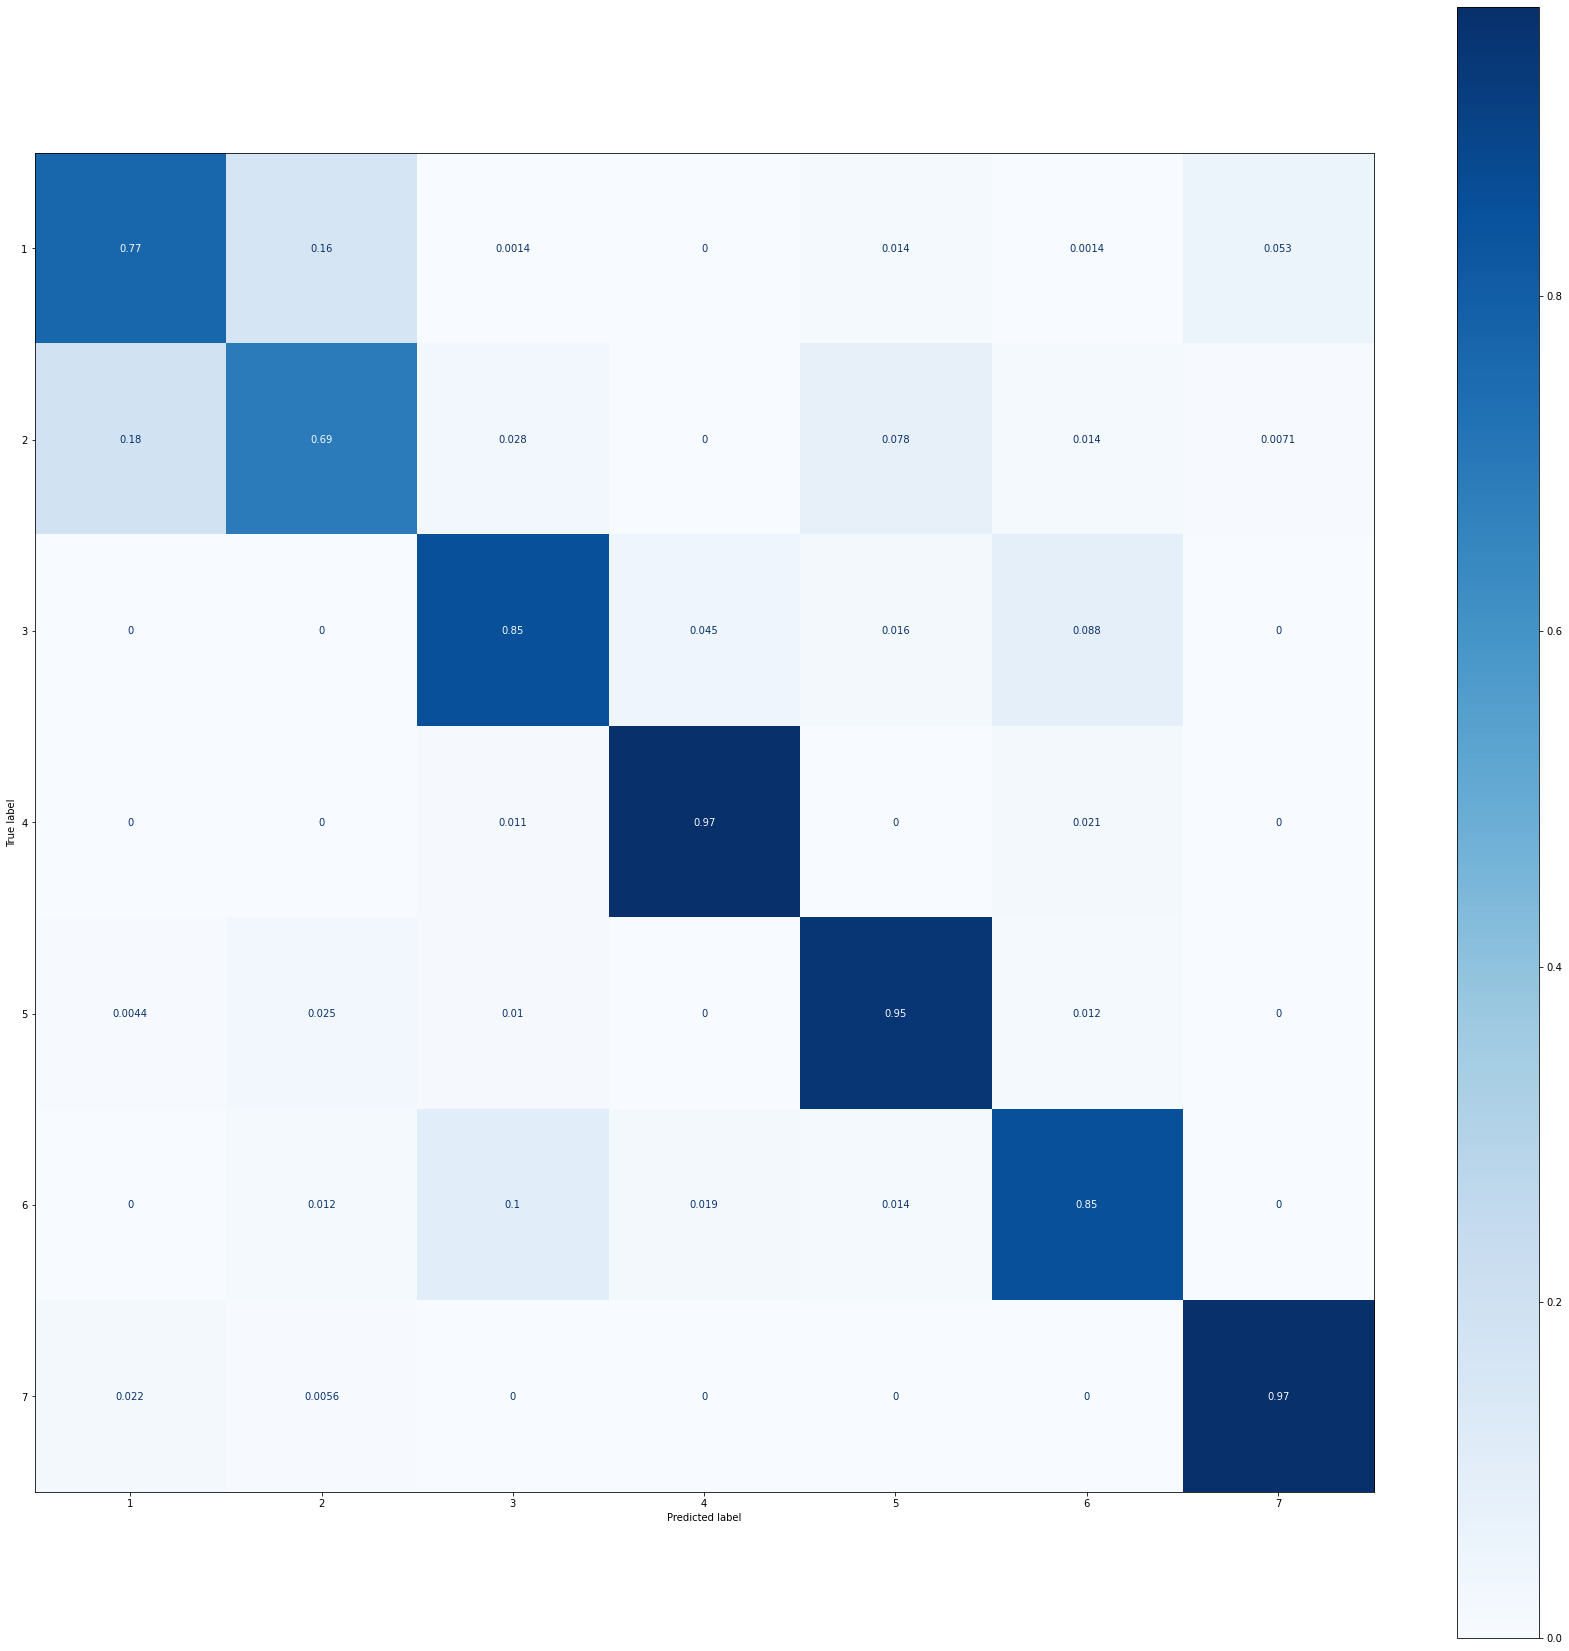

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                 

In [302]:
# Voting
models = [('et',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('hg',HistGradientBoostingClassifier(random_state=0)),
           ('rf',RandomForestClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8659391534391535
split acc: 0.8466933867735471
time taken: 76.25454878807068
[0.74858 0.65532 0.82904 0.96218 0.93411 0.84332 0.95512]


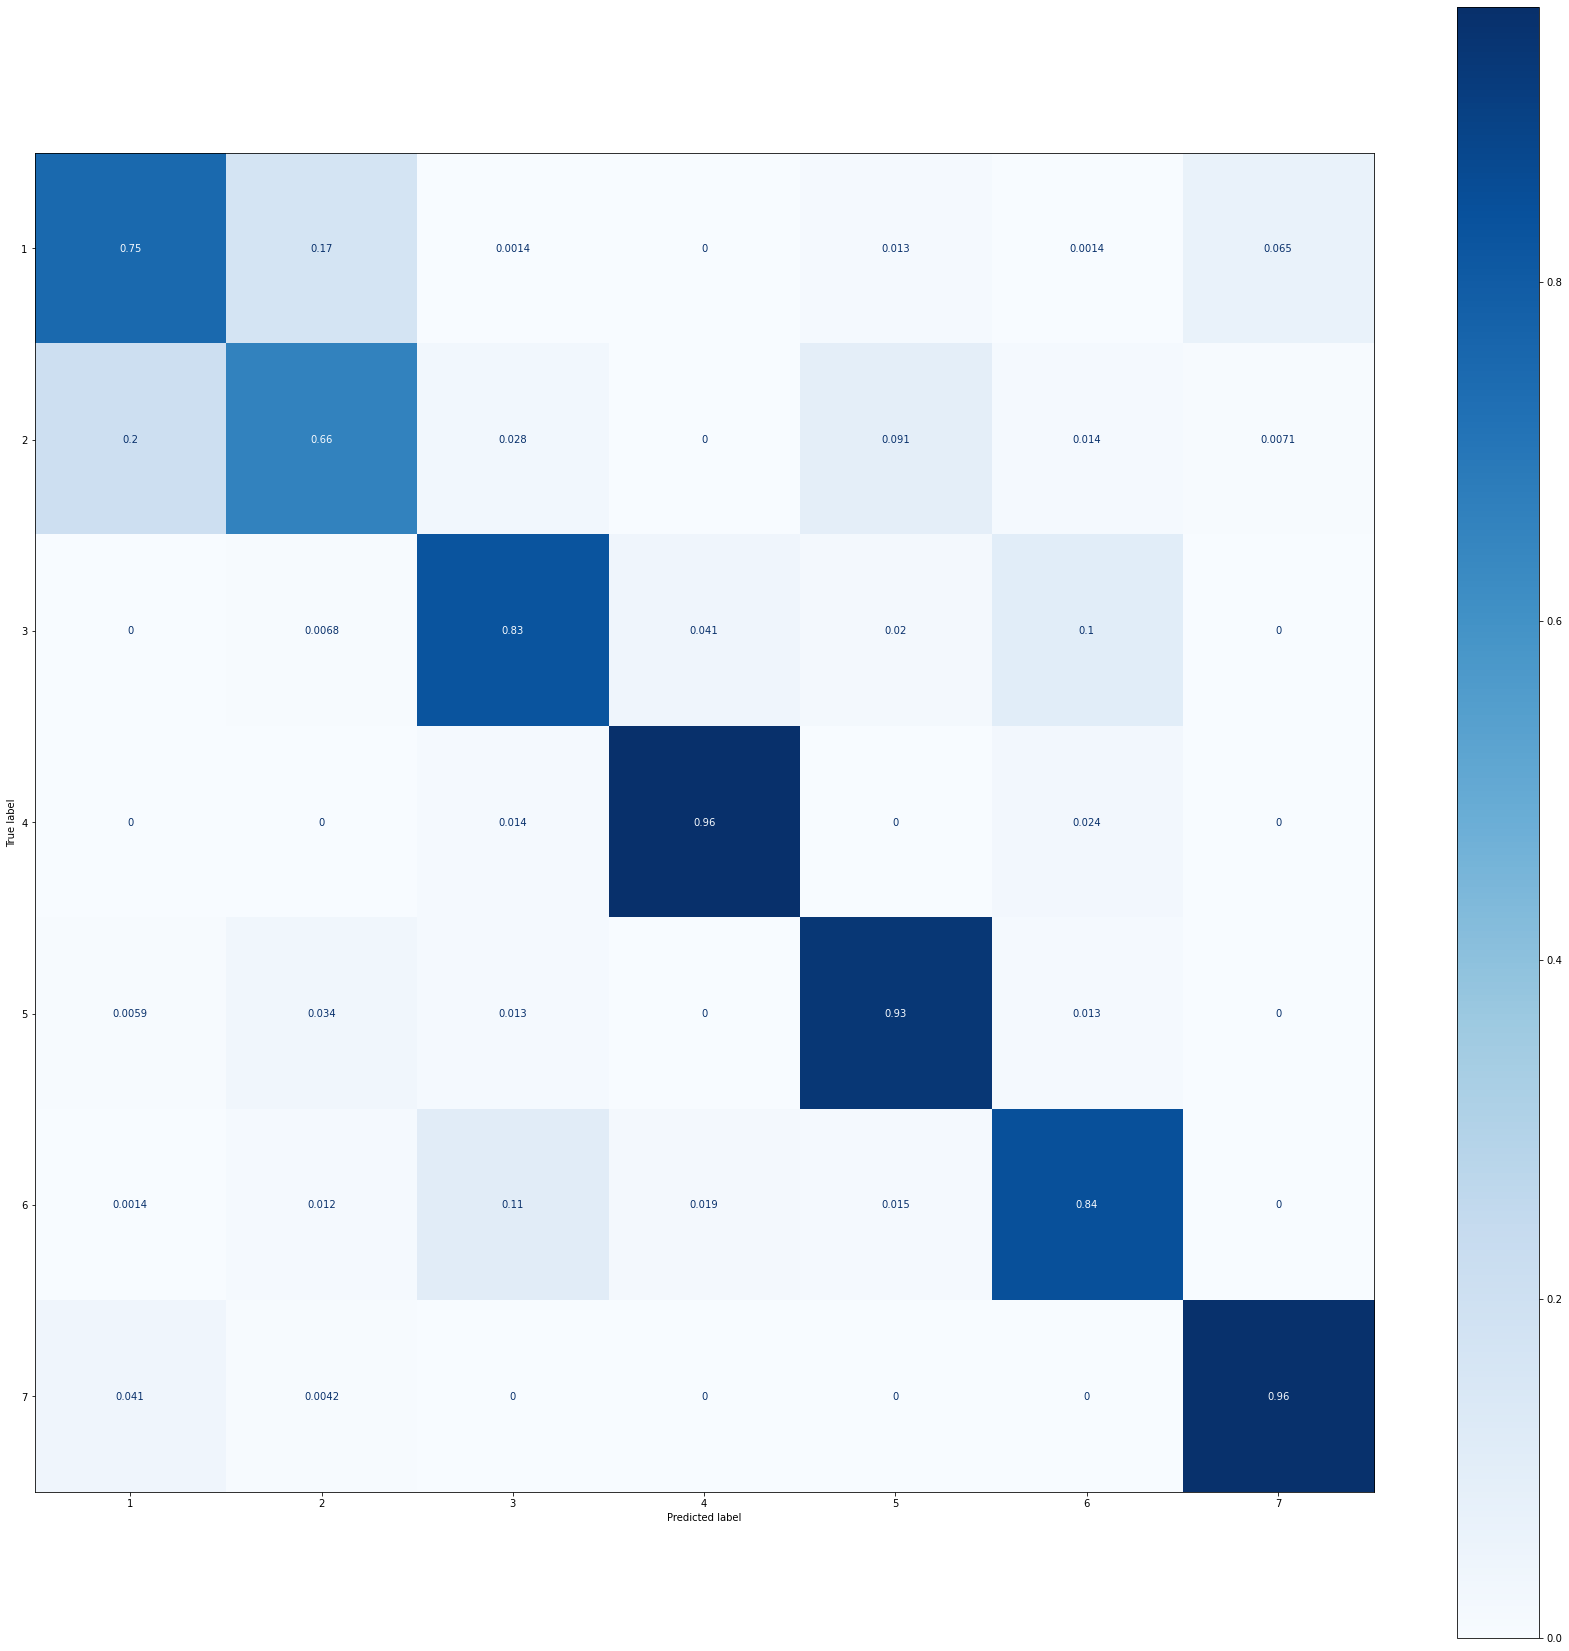

VotingClassifier(estimators=[('hg1',
                              HistGradientBoostingClassifier(l2_regularization=0.0,
                                                             learning_rate=0.1,
                                                             loss='auto',
                                                             max_bins=255,
                                                             max_depth=None,
                                                             max_iter=100,
                                                             max_leaf_nodes=31,
                                                             min_samples_leaf=20,
                                                             n_iter_no_change=None,
                                                             random_state=0,
                                                             scoring=None,
                                                             tol=1e-07,
                            

In [303]:
# Voting
models = [('hg1',HistGradientBoostingClassifier(random_state=0)),
           ('hg2',HistGradientBoostingClassifier(random_state=0)),
           ('hg3',HistGradientBoostingClassifier(random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8873677248677249
split acc: 0.8681362725450902
time taken: 25.90005135536194
[0.74574 0.71915 0.86296 0.96779 0.94729 0.85831 0.97616]


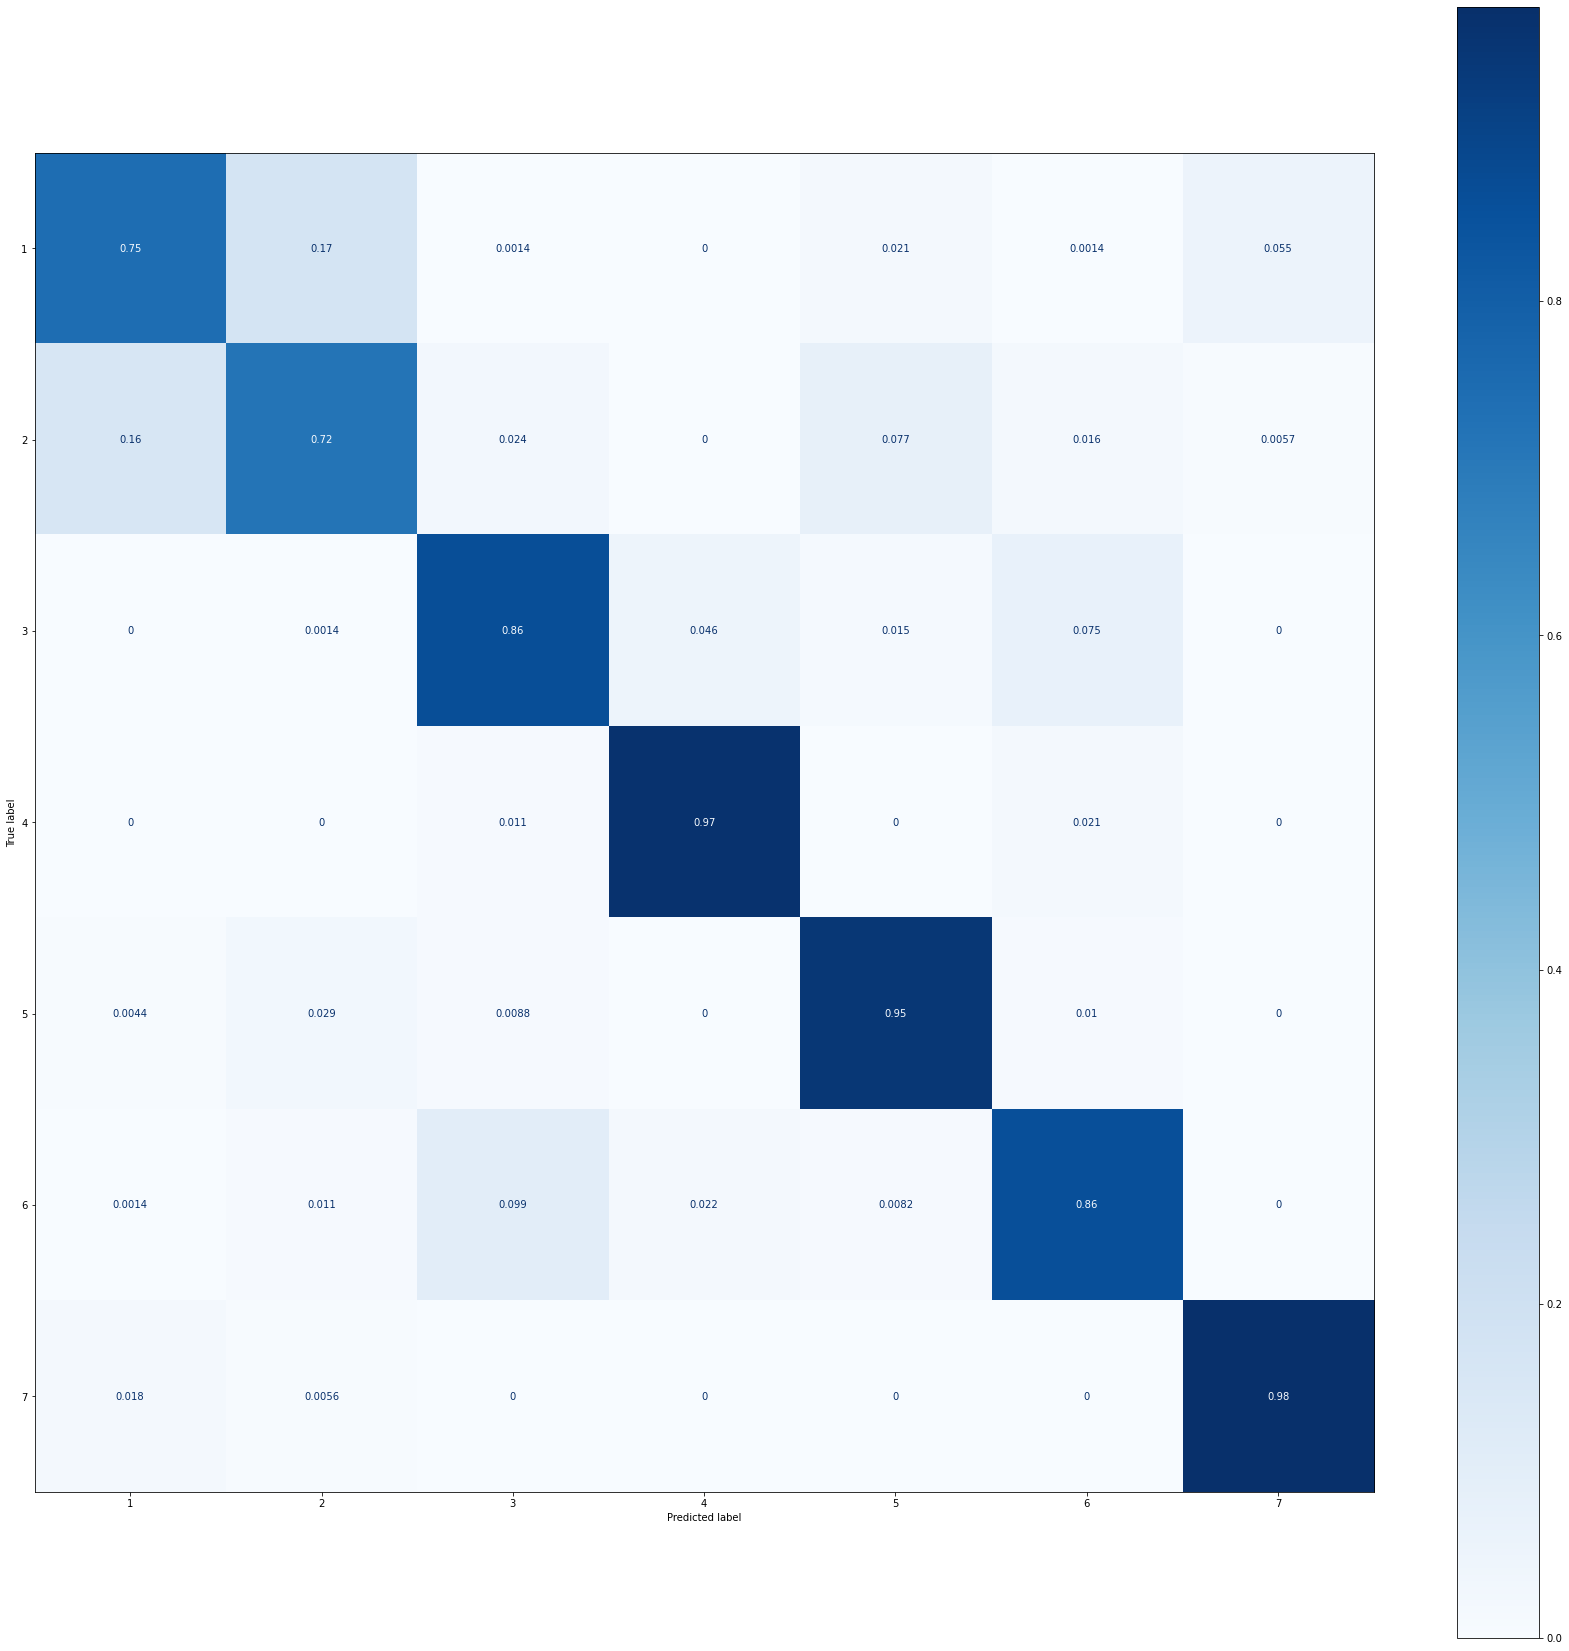

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                 

In [304]:
# Voting
models = [('et',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('et2',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('et3',ExtraTreesClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8774470899470901
split acc: 0.8585170340681363
time taken: 16.610207080841064
[0.76989 0.68794 0.83718 0.96218 0.9429  0.84332 0.96774]


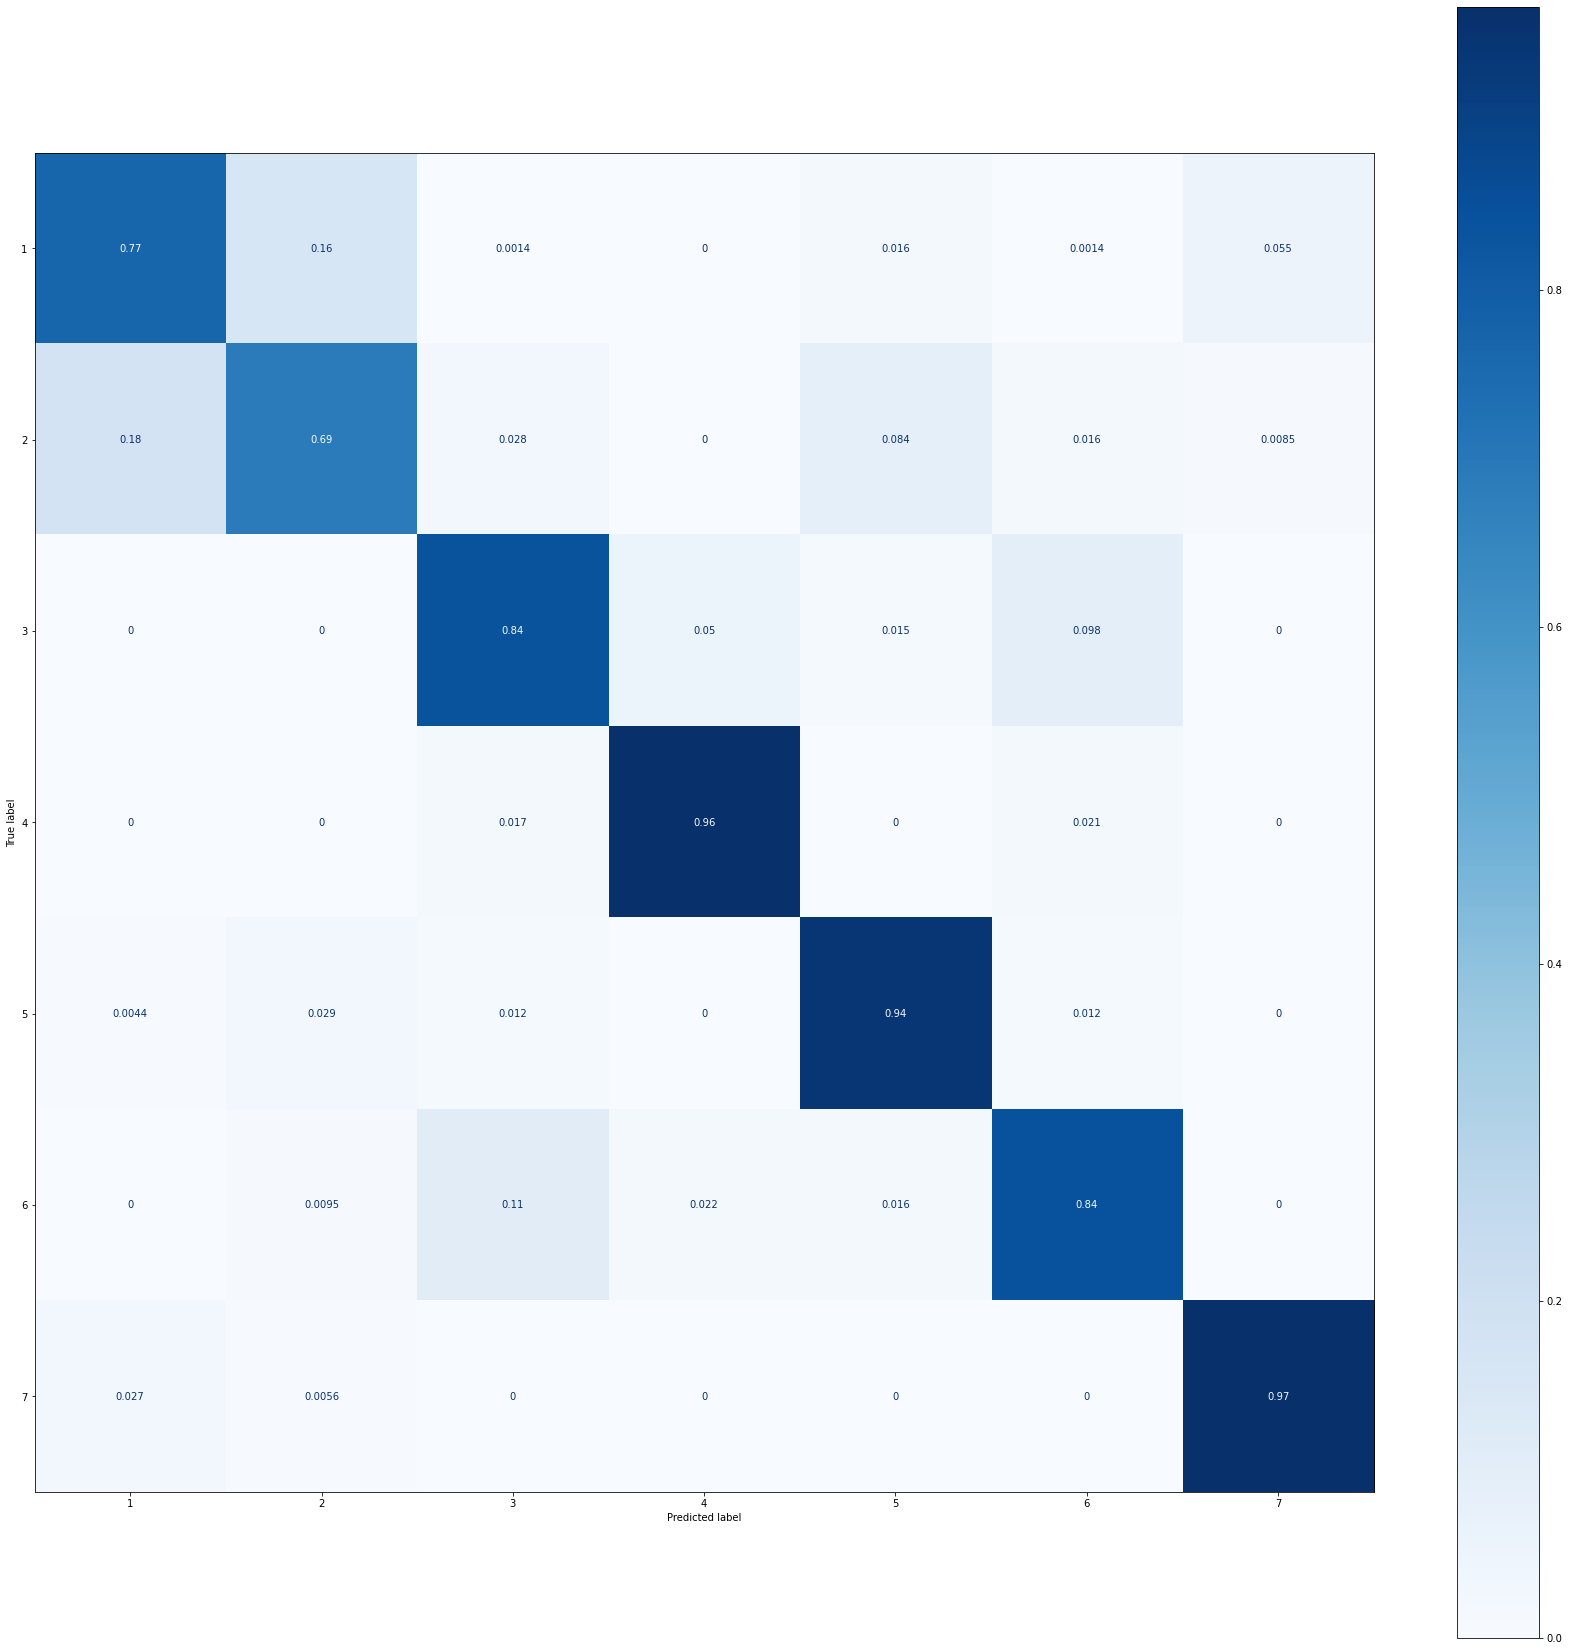

VotingClassifier(estimators=[('rf1',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
       

In [305]:
# Voting
models = [('rf1',RandomForestClassifier(n_jobs=-1, random_state=0)),
           ('rf2',RandomForestClassifier(n_jobs=-1, random_state=0)),
           ('rf3',RandomForestClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

# Feature Selection

In [336]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)
# df_train_norm.drop(columns=['Soil_Type6','Soil_Type14','Soil_Type5','Soil_Type12'],inplace=True)

cv acc: 0.890079365079365
split acc: 0.8723446893787575
time taken: 8.887207746505737
[0.7642  0.72057 0.86839 0.96779 0.95461 0.85967 0.97195]


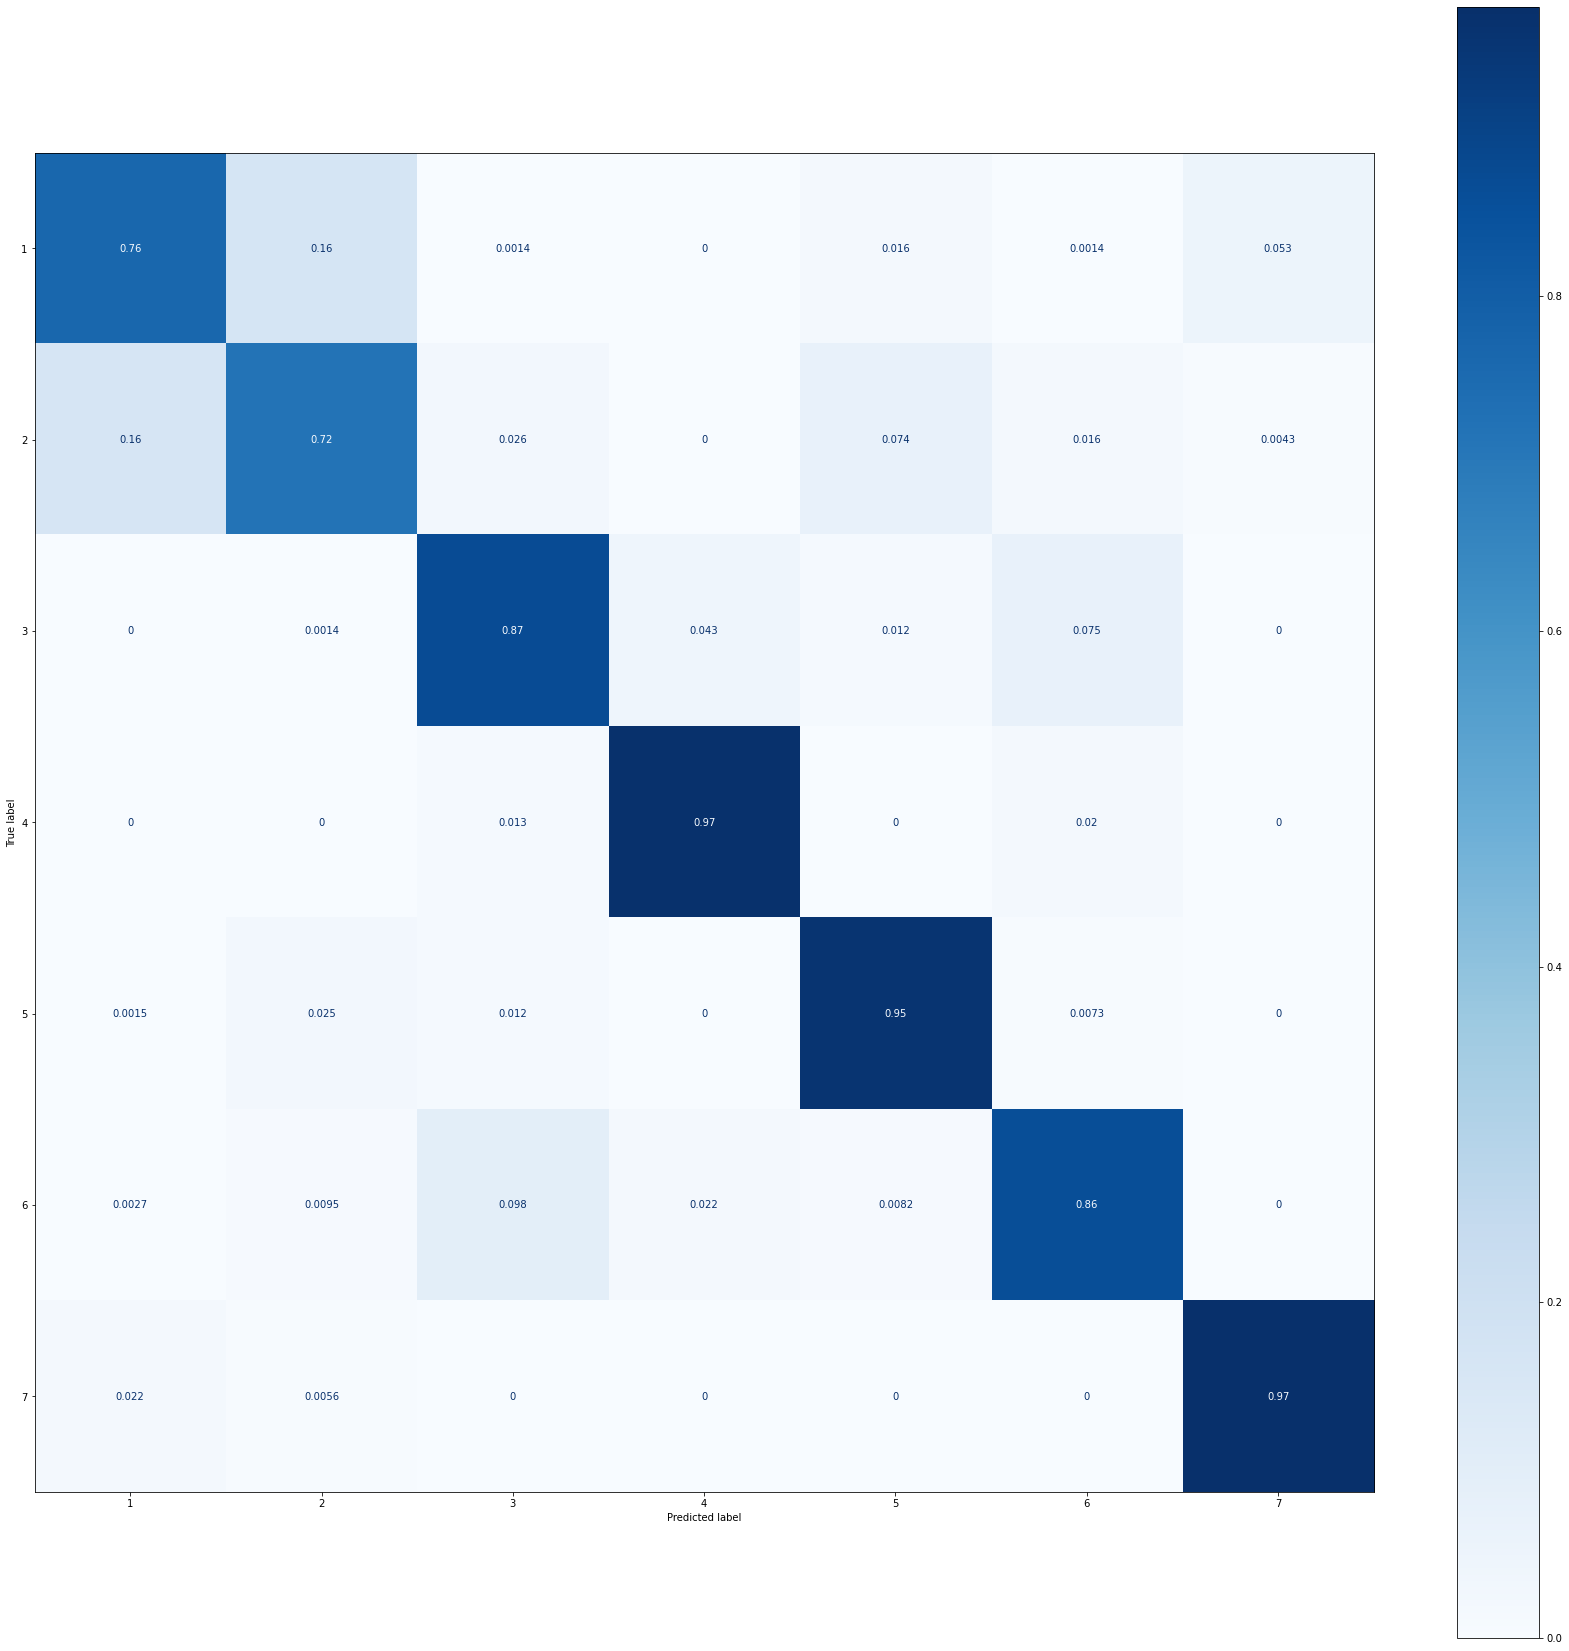

In [429]:
best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_norm, return_train = True, return_val = True)

## Cur

In [677]:
df_train_alt = df_train_norm.copy()

In [705]:
tree_size_acc = []
for n in range(100,2501,100):
    print('\n\n{}\n'.format(n)+'-'*50)
    m, acc, time_taken = score_model(ExtraTreesClassifier(n_estimators=n,n_jobs=-1, random_state=0), df_train_alt, display=False, return_acc=True, return_time=True)
    tree_size_acc.append((n,acc,time_taken))



100
--------------------------------------------------
cv acc: 0.890079365079365
split acc: 0.8723446893787575
time taken: 9.127817153930664


200
--------------------------------------------------
cv acc: 0.8916005291005291
split acc: 0.8743486973947896
time taken: 14.875203132629395


300
--------------------------------------------------
cv acc: 0.8913359788359788
split acc: 0.8749498997995993
time taken: 21.139843702316284


400
--------------------------------------------------
cv acc: 0.8917328042328041
split acc: 0.8743486973947896
time taken: 31.693469762802124


500
--------------------------------------------------
cv acc: 0.8925264550264552
split acc: 0.8749498997995993
time taken: 38.61263990402222


600
--------------------------------------------------
cv acc: 0.8929232804232804
split acc: 0.8755511022044088
time taken: 49.16523027420044


700
--------------------------------------------------
cv acc: 0.8921296296296297
split acc: 0.8761523046092184
time taken: 57.54061

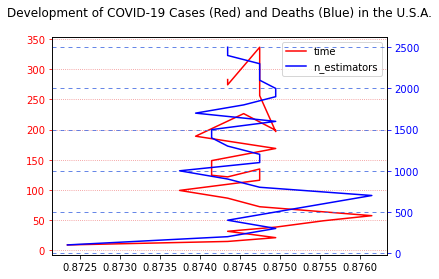

In [792]:
fig, ax = plt.subplots()
# ax1 for # time
l1 = ax.plot(np.array(tree_size_acc)[:,1], np.array(tree_size_acc)[:,2], 'r', label='time')
ax.tick_params('y', colors='r')
ax.grid(axis='y', color='lightcoral', linestyle=':')
# ax2 for # n_estimators
ax2 = ax.twinx()
l2 = ax2.plot(np.array(tree_size_acc)[:,1], np.array(tree_size_acc)[:,0], 'b', label='n_estimators')
ax2.tick_params('y', colors='b')
ax2.grid(axis='y', color='royalblue', linestyle=(0,(5,5)))
# general plot
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines,labels)
plt.title("Development of COVID-19 Cases (Red) and Deaths (Blue) in the U.S.A.\n")
plt.show()

cv acc: 0.8712962962962963
split acc: 0.8492985971943888
time taken: 3.1655149459838867
[0.75568 0.68369 0.83853 0.96499 0.92679 0.8079  0.96914]


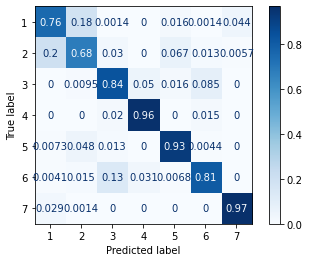

Soil_Type7 0.0
Soil_Type15 0.0
Soil_Type8 1.928416681144859e-05
Soil_Type25 4.902435764614069e-05
Soil_Type9 0.00016033149432977348
Soil_Type28 0.0002326245313427903
Soil_Type36 0.0002856561814832906
Soil_Type27 0.00032551703361318927
Soil_Type26 0.0004151246979854782
Soil_Type34 0.00047519740583535524
Soil_Type19 0.0005718482233546111
Soil_Type21 0.0006153968706320373
Soil_Type18 0.0006404434156599212
Soil_Type37 0.001028723935672891
Soil_Type5 0.001313263032110075
Soil_Type20 0.0015981572147514627
Soil_Type1 0.0016041571956264085
Soil_Type16 0.0021266523853257146
Soil_Type14 0.0022398649805563066
Soil_Type31 0.002747735879817
Soil_Type33 0.0034156912131042575
Soil_Type24 0.0036451158918760474
Soil_Type6 0.0041809590373834945
Soil_Type35 0.004307274472497212
Wilderness_Area2 0.004476432241647044
Soil_Type11 0.004843192298290665
Soil_Type32 0.005779927006481328
Soil_Type29 0.006078835808397891
Soil_Type22 0.006428014258551161
Soil_Type23 0.006838278440039771
Soil_Type12 0.0071805967588

In [795]:
m, m_train_x, m_train_y, m_val_x, m_val_y = score_model(ExtraTreesClassifier(n_estimators=10,n_jobs=-1, random_state=0), df_train_alt, return_train=True, return_val=True, show_weights=True)

# Alt

In [ ]:
# Catboost

In [714]:
# XGBoost

In [715]:
# Light GBM

In [721]:
m_train_x, m_train_y, m_val_x, m_val_y

(array([[2.97700e+03, 2.91609e-02, 8.16504e-03, ..., 0.00000e+00,
         0.00000e+00, 7.38833e+00],
        [3.37700e+03, 3.27817e-02, 1.35182e-03, ..., 0.00000e+00,
         0.00000e+00, 7.35308e+00],
        [2.72800e+03, 1.35070e-01, 9.41397e-03, ..., 0.00000e+00,
         0.00000e+00, 7.06305e+00],
        ...,
        [3.51500e+03, 4.59234e-02, 7.84767e-03, ..., 0.00000e+00,
         0.00000e+00, 8.07776e+00],
        [2.57500e+03, 3.95788e-02, 1.73157e-02, ..., 0.00000e+00,
         0.00000e+00, 7.42536e+00],
        [2.73800e+03, 1.42281e-01, 4.21226e-03, ..., 0.00000e+00,
         0.00000e+00, 7.57712e+00]]),
 array([2, 7, 6, ..., 7, 3, 5], dtype=int64),
 array([[2.22000e+03, 1.87704e-02, 1.25136e-02, ..., 0.00000e+00,
         0.00000e+00, 6.72022e+00],
        [2.13900e+03, 9.95033e-02, 8.36162e-03, ..., 0.00000e+00,
         0.00000e+00, 6.83948e+00],
        [2.29200e+03, 6.31821e-02, 1.50710e-02, ..., 0.00000e+00,
         0.00000e+00, 6.77651e+00],
        ...,
        

In [796]:
# NN
model = Sequential()
model.add( Dense(20, input_dim=m_train_x.shape[1], activation='relu'))
model.add( Dense(50, activation='relu'))
model.add( Dense(7, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 20)                1120      
_________________________________________________________________
dense_35 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_36 (Dense)             (None, 7)                 357       
Total params: 2,527
Trainable params: 2,527
Non-trainable params: 0
_________________________________________________________________


In [739]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=2)
# score_model(estimator, df_train_alt)
# results = model_selection.cross_val_score(model, X, Y, cv=kfold)

df = df_train_alt
X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
results = model_selection.cross_val_score(estimator, X, Y, cv=kfold)
print('cv acc:', results.mean())

In [764]:
enc = OneHotEncoder()
new_train_y = enc.fit_transform(m_train_y.reshape(-1,1))
new_val_y = enc.transform(m_val_y.reshape(-1,1))

In [766]:
model.fit(m_train_x, new_y, validation_data=(m_val_x,new_val_y), epochs=500, batch_size=5, verbose=2)

Train on 10130 samples, validate on 4990 samples
Epoch 1/500
 - 2s - loss: 0.8193 - acc: 0.6509 - val_loss: 0.8254 - val_acc: 0.6425
Epoch 2/500
 - 2s - loss: 0.8228 - acc: 0.6528 - val_loss: 0.7868 - val_acc: 0.6617
Epoch 3/500
 - 2s - loss: 0.8150 - acc: 0.6480 - val_loss: 0.8535 - val_acc: 0.6521
Epoch 4/500
 - 2s - loss: 0.8256 - acc: 0.6477 - val_loss: 0.8173 - val_acc: 0.6527
Epoch 5/500
 - 2s - loss: 0.8137 - acc: 0.6473 - val_loss: 0.8046 - val_acc: 0.6565
Epoch 6/500
 - 2s - loss: 0.8184 - acc: 0.6500 - val_loss: 0.8493 - val_acc: 0.6355
Epoch 7/500
 - 2s - loss: 0.8161 - acc: 0.6497 - val_loss: 0.8514 - val_acc: 0.6367
Epoch 8/500
 - 2s - loss: 0.8159 - acc: 0.6515 - val_loss: 0.8401 - val_acc: 0.6485
Epoch 9/500
 - 2s - loss: 0.8208 - acc: 0.6494 - val_loss: 0.7991 - val_acc: 0.6583
Epoch 10/500
 - 2s - loss: 0.8197 - acc: 0.6509 - val_loss: 0.7992 - val_acc: 0.6617
Epoch 11/500
 - 2s - loss: 0.8155 - acc: 0.6481 - val_loss: 0.7834 - val_acc: 0.6713
Epoch 12/500
 - 2s - loss

KeyboardInterrupt: 

In [779]:
df_train_norm[soils].apply(np.sum)

Soil_Type1      355
Soil_Type2      623
Soil_Type3      962
Soil_Type4      843
Soil_Type5      165
Soil_Type6      650
Soil_Type7        0
Soil_Type8        1
Soil_Type9       10
Soil_Type10    2142
Soil_Type11     406
Soil_Type12     227
Soil_Type13     476
Soil_Type14     169
Soil_Type15       0
Soil_Type16     114
Soil_Type17     612
Soil_Type18      60
Soil_Type19      46
Soil_Type20     139
Soil_Type21      16
Soil_Type22     345
Soil_Type23     757
Soil_Type24     257
Soil_Type25       1
Soil_Type26      54
Soil_Type27      15
Soil_Type28       9
Soil_Type29    1291
Soil_Type30     725
Soil_Type31     332
Soil_Type32     690
Soil_Type33     616
Soil_Type34      22
Soil_Type35     102
Soil_Type36      10
Soil_Type37      34
Soil_Type38     728
Soil_Type39     657
Soil_Type40     459
dtype: int64